In [1]:
import os
import clip
import torch
from PIL import Image
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
from torch.utils.data import Subset
from tqdm import tqdm
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import random
from sklearn.model_selection import train_test_split, GridSearchCV

print(f'{torch.__version__}')

1.7.1


In [2]:
test_root = 'Test/Test_all/'
test_csv = 'Test/submission_example.csv'

In [5]:
# 若沒有使用外部transform, 則需要自己將feature和label轉為torch.tensor
# 要注意pytorch的影像格式是(3, 224, 224), 跟其他不一樣
# 圖片照類別分在不同資料夾, 因此CSV中的檔名已經是完整路徑
class CustomDatasetFromImages(Dataset):
    def __init__(self, csv_path, img_root, transform=None, target_transform=None):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.csv_path = csv_path
        self.img_root = img_root
        
        # Transforms
        self.transform = transform
        # Target_transform
        self.target_transform = target_transform
        # Read the csv file
        self.data_info = pd.read_csv(self.csv_path)
        # First column contains the image paths
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        # Second column is the labels
        self.label_arr = np.asarray(self.data_info.iloc[:, 1])
        
        
        # Calculate len
        self.len = len(self.data_info.index)


    def __getitem__(self, i):
        index = i 
#         print("iters={},index={}".format(iter_num, index))
        # Get image name from the pandas df
        single_image_name = self.image_arr[index]
        single_image_name = os.path.join(self.img_root, single_image_name) # csv檔名若已經是完整路徑, 不用再加
        # Open image
        img = Image.open(single_image_name).convert('RGB') # 讀檔時轉為RGB
        
        # If there is an transform
        if self.transform:
            img = self.transform(img)
#         if self.target_transform:
#             label = self.target_transform(label)
        
        # Transform image to tensor
#         img_as_tensor = self.to_tensor(img_as_img)
        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]

        return (img, single_image_label)

    def __len__(self):
        self.data_len = self.len
        return self.data_len

In [12]:
# Linear Probe 只用image-encoder, 沒用到text-encoder
def get_features(dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy()

In [13]:
# Load the model, 可改其他model
device = "cuda" if torch.cuda.is_available() else "cpu"
# model, preprocess = clip.load('ViT-B/32', device)
model, preprocess = clip.load('ViT-L/14', device) 

In [14]:
# Call dataset
dataset =  CustomDatasetFromImages(csv_path=test_csv, img_root=test_root, transform=preprocess)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('A',)


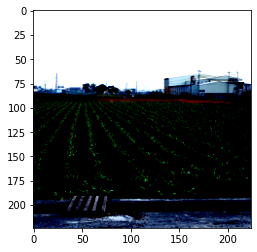

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('A',)


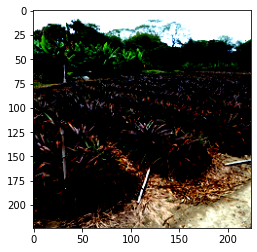

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('A',)


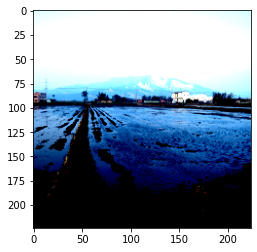

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('A',)


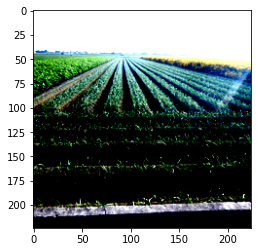

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('A',)


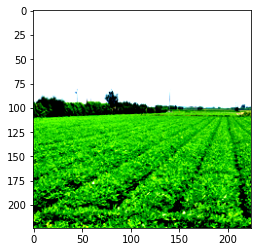

In [15]:
# 測試讀取dataset中資料
cnt = 0
for image, label in DataLoader(dataset, batch_size=1):
    print(label)
    img = image[0]
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    plt.show()
    cnt += 1
    if cnt == 5:
        break

In [17]:
import time
# Calculate the image features
start = time.time()
test_features = get_features(dataset)

end = time.time()
print(f'Time: {end-start}')

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [1:08:09<00:00, 20.45s/it]

Time: 4089.7651755809784


In [18]:
np.save('test_features_ViTL14', test_features)
